# Monte-Carlo Asian Options 

On se propose ici d'étudier une méthode de simulation numérique pour simuler le prix d'un call asiatique. Ensuite nous implémenterons des méthodes de réduction de la variance.

In [ ]:
import numpy as np
from scipy import stats
from  math import log, sqrt, exp
import matplotlib.pyplot as plt

In [ ]:
# Paramètres
S0 = np.linspace(80, 120, 41)
K = 100
T = 1
r = 0.05
sigma = 0.2
N_comparison = 10000
np.random.seed(1)
N_max = 1000
N_min = 100
N_iter = 20
S0_unique = np.array([100])
N_sim = np.linspace(N_min, N_max, N_iter)
N = 1000
S0 = np.linspace(80, 120, 41)
Number_prices = 10

#  1) Tracer le prix de l’option asiatique en fonction de S_0. Comparer au prix du call européen de mêmes strike et maturité.



In [ ]:
def call_european(T, K, r, S, sigma):
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

def call_asian(T, K, r, S0, sigma, N):
  asian_option_prices = []
  dt = T / N
  for s in S0:
      simulated_prices = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), size=(N, N))
      average_price = np.mean(np.exp(np.cumsum(simulated_prices, axis=1)) * s, axis=1)
      payoff = np.maximum(average_price - K, 0)
      asian_option_prices.append(np.exp(-r * T) * np.mean(payoff))
  return asian_option_prices

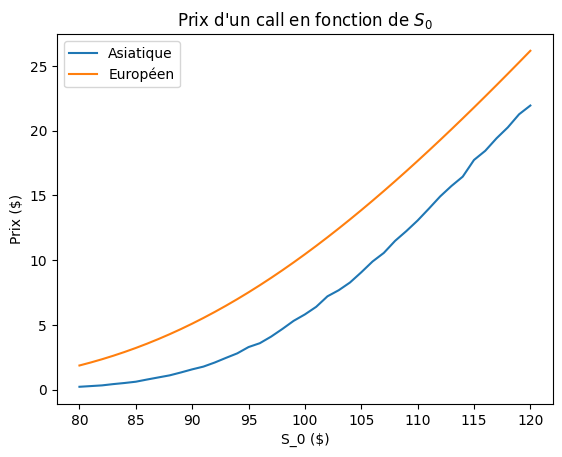

In [ ]:
asian_option_prices = call_asian(T, K, r, S0, sigma, N_comparison)
european_option_prices = call_european(T, K, r, S0, sigma)

plt.plot(S0, asian_option_prices, label='Asiatique')
plt.plot(S0, european_option_prices, label='Européen')
plt.title("Prix d'un call en fonction de $S_0$")
plt.xlabel('S_0 ($)')
plt.ylabel('Prix ($)')
plt.legend()
plt.show()


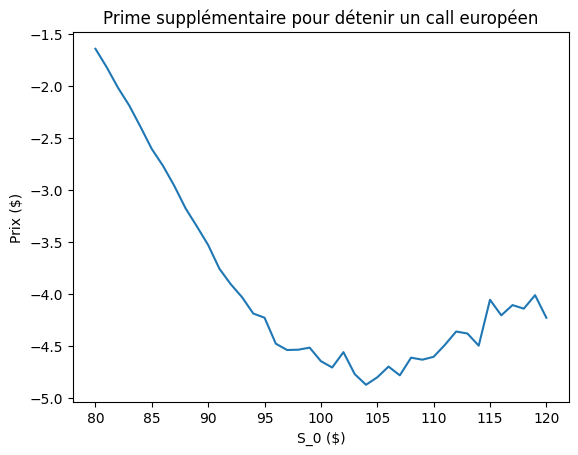

In [ ]:
sur_prime = (asian_option_prices-european_option_prices)
plt.plot(S0, sur_prime)
plt.title("Prime supplémentaire pour détenir un call européen")
plt.xlabel('S_0 ($)')
plt.ylabel('Prix ($)')
plt.show()

Nous remarquons que le prix d'un call européen est plus élevé que celui d'un call asiatique. Cela s'explique par le fait que le détenteur d'une option asiatique "lisse" son risque. Il peut donc s'affanchir d'une prime pour payer ce risque, sinon il y aurait des opportunités d'arbitrage. De plus, nous remarquons que cette prime supplémentaire à tendance à augmenter lorsque l'option est dans la monnaie.

# 2) Etudier le comportement du prix de l’option asiatique en fonction du nombre de dates d’observations N.


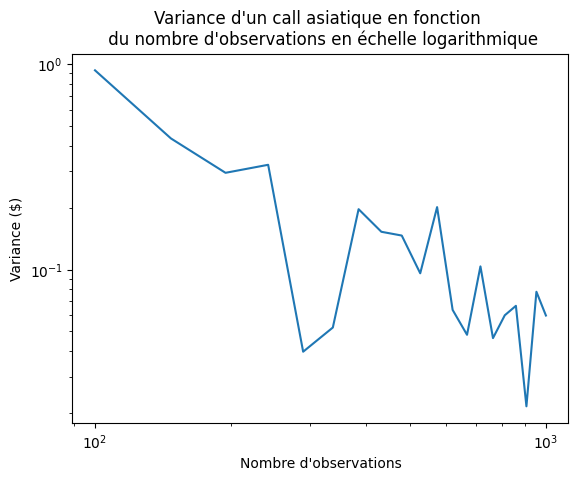

In [ ]:
asian_var = np.zeros(len(N_sim))
for i, n_sim in enumerate(N_sim):
  n = int(n_sim)
  asian = []
  for _ in range(Number_prices):
    asian.append(call_asian(T, K, r, S0_unique, sigma, n))
  asian_var[i] = np.var(asian)

plt.plot(N_sim, asian_var)
plt.xlabel("Nombre d'observations")
plt.ylabel("Variance ($)")
plt.yscale("log")
plt.xscale("log")
plt.title("Variance d'un call asiatique en fonction \n du nombre d'observations en échelle logarithmique")
plt.show()

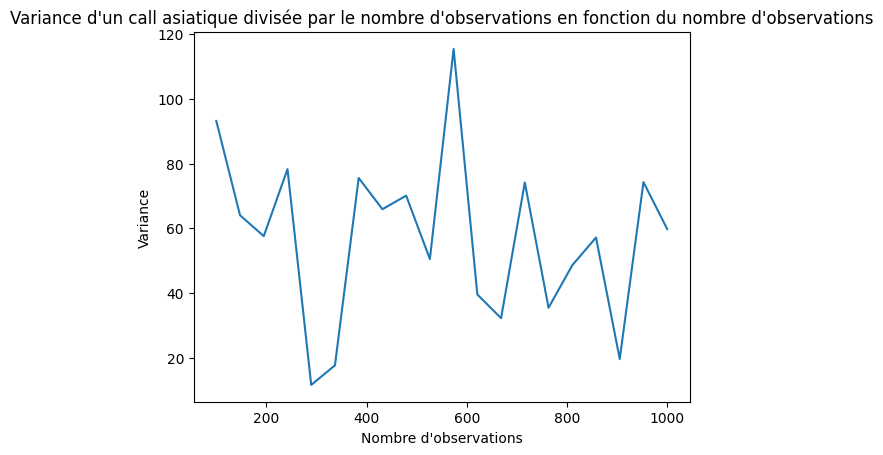

In [ ]:
Cv_values = 1/N_sim
plt.plot(N_sim, asian_var*N_sim)
plt.xlabel("Nombre d'observations")
plt.ylabel("Variance")
plt.title("Variance d'un call asiatique divisée par le nombre d'observations en fonction du nombre d'observations")
plt.show()

Nous remarquons que la variance d'un call asiatique décroit en 1/n où n est le nombre d'observations.

# 3) Analyse des méthodes de réductions de variance

In [ ]:
def call_asian_antithetic(T, K, r, S0, sigma, N):
  asian_option_prices_antithetic = []
  dt = T / N
  for s in S0:
    simulated_prices = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), size=(N//2, N))
    simulated_prices = np.concatenate((simulated_prices, -simulated_prices), axis=0)
    average_price = np.mean(np.exp(np.cumsum(simulated_prices, axis=1)) * s, axis=1)
    payoff = np.maximum(average_price - K, 0)
    asian_option_prices_antithetic.append(np.exp(-r * T) * np.mean(payoff))
  return asian_option_prices_antithetic

def call_asian_control_ST(T, K, r, S0, sigma, N):
  asian_option_prices_with_control = []
  dt = T / N
  for s in S0:
    simulated_prices = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), size=(N//2, N))
    simulated_prices = np.concatenate((simulated_prices, -simulated_prices), axis=0)
    average_price = np.mean(np.exp(np.cumsum(simulated_prices, axis=1)) * s, axis=1)
    payoff = np.maximum(average_price - K, 0)
    Z = average_price
    covariance = np.cov(payoff, Z)
    c = -covariance[0,1]/covariance[1,1]
    asian_option_prices_with_control.append(np.exp(-r * T) * np.mean(payoff+ c*(Z - np.mean(Z))))

  return asian_option_prices_with_control

def call_asian_control_exp(T, K, r, S0, sigma, N):
  asian_option_prices_with_control = []
  dt = T / N
  for s in S0:
    simulated_prices = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), size=(N//2, N))
    simulated_prices = np.concatenate((simulated_prices, -simulated_prices), axis=0)
    average_price = np.mean(np.exp(np.cumsum(simulated_prices, axis=1)) * s, axis=1)
    payoff = np.maximum(average_price - K, 0)
    Z = np.exp(-r * T)*payoff
    covariance = np.cov(payoff, Z)
    c = -covariance[0,1]/covariance[1,1]
    asian_option_prices_with_control.append(np.exp(-r * T) * np.mean(payoff+ c*(Z - np.mean(Z))))

  return asian_option_prices_with_control


In [ ]:
asian_option_prices = call_asian(T, K, r, S0, sigma, N)
asian_antithetic_option_prices = call_asian_antithetic(T, K, r, S0, sigma, N)
call_asian_control_ST_option_prices = call_asian_control_ST(T, K, r, S0, sigma, N)
call_asian_control_exp_option_prices = call_asian_control_exp(T, K, r, S0, sigma, N)

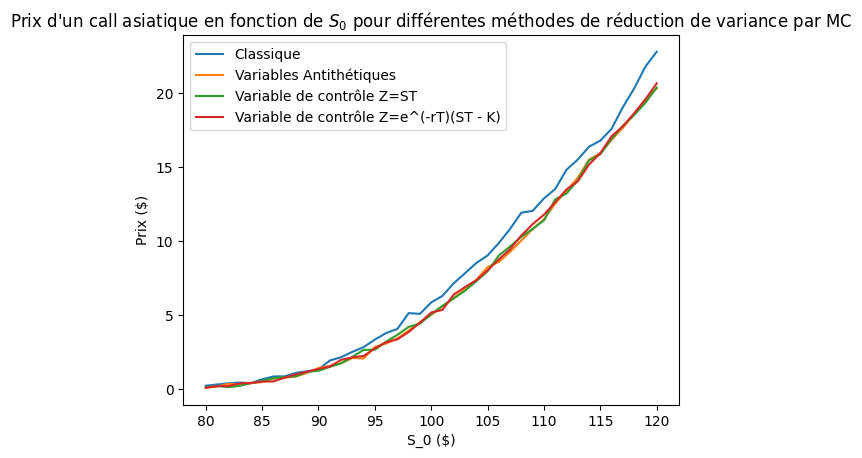

In [ ]:
plt.plot(S0, asian_option_prices, label="Classique")
plt.plot(S0, asian_antithetic_option_prices, label="Variables Antithétiques")
plt.plot(S0, call_asian_control_ST_option_prices, label="Variable de contrôle Z=ST")
plt.plot(S0, call_asian_control_exp_option_prices, label="Variable de contrôle Z=e^(-rT)(ST - K)")
plt.title("Prix d'un call asiatique en fonction de $S_0$ pour différentes méthodes de réduction de variance par MC")
plt.xlabel("S_0 ($)")
plt.ylabel("Prix ($)")
plt.legend()
plt.show()

In [ ]:
asian_var = np.zeros(len(N_sim))
asian_antithetic_var = np.zeros(len(N_sim))
asian_control_st_var = np.zeros(len(N_sim))
asian_control_exp_var = np.zeros(len(N_sim))
for i, n_sim in enumerate(N_sim):
  n = int(n_sim)
  asian = []
  asian_antithetic = []
  asian_control_st = []
  asian_control_exp = []
  for _ in range(Number_prices):
    asian.append(call_asian(T, K, r, S0_unique, sigma, n))
    asian_antithetic.append(call_asian_antithetic(T, K, r, S0_unique, sigma, n))
    asian_control_st.append(call_asian_control_ST(T, K, r, S0_unique, sigma, n))
    asian_control_exp.append(call_asian_control_exp(T, K, r, S0_unique, sigma, n))
  asian_var[i] = np.var(asian)
  asian_antithetic_var[i] = np.var(asian_antithetic)
  asian_control_st_var[i] = np.var(asian_control_st)
  asian_control_exp_var[i] = np.var(asian_control_exp)

Text(0.5, 1.0, "Variance d'un call asiatique en fonction du nombre \n de simulations de MC pour différentes méthodes de réduction \n de variance en échelle logarithmique")

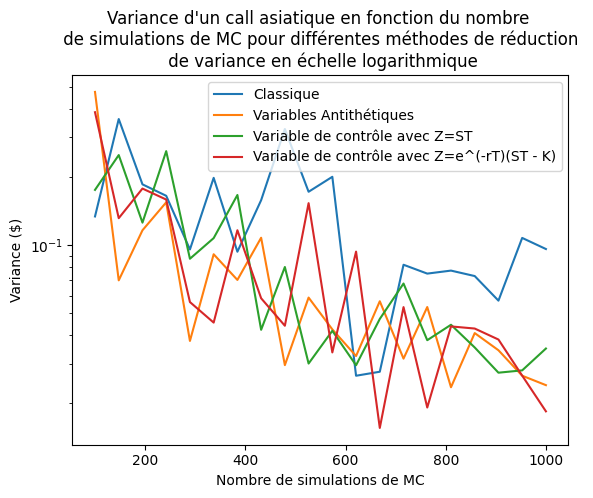

In [ ]:
plt.plot(N_sim, asian_var, label="Classique")
plt.plot(N_sim, asian_antithetic_var, label="Variables Antithétiques")
plt.plot(N_sim, asian_control_st_var, label="Variable de contrôle avec Z=ST")
plt.plot(N_sim, asian_control_exp_var, label="Variable de contrôle avec Z=e^(-rT)(ST - K)")
plt.legend()
plt.yscale("log")
plt.ylabel("Variance ($)")
plt.xlabel("Nombre de simulations de MC")
plt.title("Variance d'un call asiatique en fonction du nombre \n de simulations de MC pour différentes méthodes de réduction \n de variance en échelle logarithmique")

Text(0.5, 1.0, 'Facteur de réduction de variance en fonction du nombre de simulations')

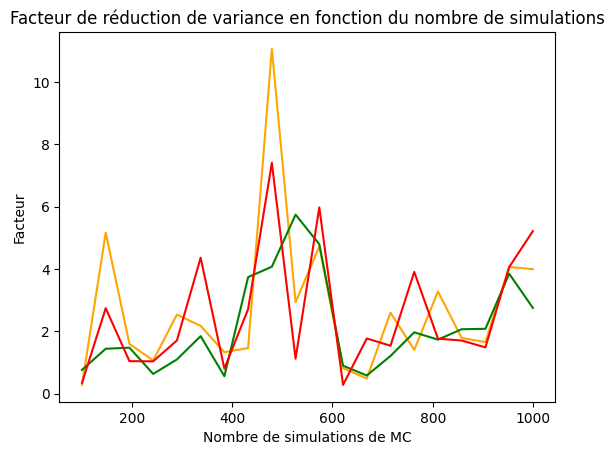

In [ ]:
plt.plot(N_sim, asian_var/asian_antithetic_var, label="Variables Antithétiques", color='orange')
plt.plot(N_sim, asian_var/asian_control_st_var, label="Variable de contrôle avec Z=ST", color='green')
plt.plot(N_sim, asian_var/asian_control_exp_var, label="Variable de contrôle avec Z=e^(-rT)(ST - K)", color='red')
plt.ylabel("Facteur")
plt.xlabel("Nombre de simulations de MC")
plt.title("Facteur de réduction de variance en fonction du nombre de simulations")

In [ ]:
reduc_antithetic = np.mean(asian_var/asian_antithetic_var)
reduc_control_st = np.mean(asian_var/asian_control_st_var)
reduc_control_exp = np.mean(asian_var/asian_control_exp_var)
print("Facteur moyen de réduction")
print("Méthode antithetique :", np.round(reduc_antithetic,2))
print("Méthode de variable de contrôle Z=ST :", np.round(reduc_antithetic,2))
print("Méthode de variable de contrôle Z=e^(-rT)(ST - K) :", np.round(reduc_antithetic,2))

Facteur moyen de réduction
Méthode antithetique : 2.72
Méthode de variable de contrôle Z=ST : 2.72
Méthode de variable de contrôle Z=e^(-rT)(ST - K) : 2.72


# 4) Utilisation du prix d’une option asiatique à moyenne géométrique pour contrôler la variance lors de l’évaluation Monte Carlo de l’option asiatique à moyenne arithmétique.

In [ ]:
def call_geo_asian(T, K, r, S0, sigma, N):
    Nt = T / N
    sigsqT = sigma**2 * T * (2 * Nt + 1) / (6 * Nt + 6)
    muT = 0.5 * sigsqT + 0.5 * (r - 0.5 * sigma**2) * T
    d1 = (np.log(S0 / K) + (muT + 0.5 * sigsqT)) / (np.sqrt(sigsqT))
    d2 = d1 - np.sqrt(sigsqT)
    return np.exp(-r * T) * (S0 * np.exp(muT) * stats.norm.cdf(d1) - K * stats.norm.cdf(d2))

In [ ]:
def call_asian_control_geo(T, K, r, S0, sigma, N):
  asian_option_prices_with_control = []
  dt = T / N
  for s in S0:
    simulated_prices = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), size=(N//2, N))
    simulated_prices = np.concatenate((simulated_prices, -simulated_prices), axis=0)
    average_price = np.mean(np.exp(np.cumsum(simulated_prices, axis=1)) * s, axis=1)
    payoff = np.maximum(average_price - K, 0)
    geo_price = call_geo_asian(T, K, r, s, sigma, N)
    Z = np.repeat(geo_price, len(payoff))
    covariance = np.cov(payoff, Z)
    if covariance[1,1] != 0.:
      c = -covariance[0,1]/covariance[1,1]
    else:
      c = 1
    asian_option_prices_with_control.append(np.exp(-r * T) * np.mean(payoff+ c*(Z - np.mean(Z))))

  return asian_option_prices_with_control

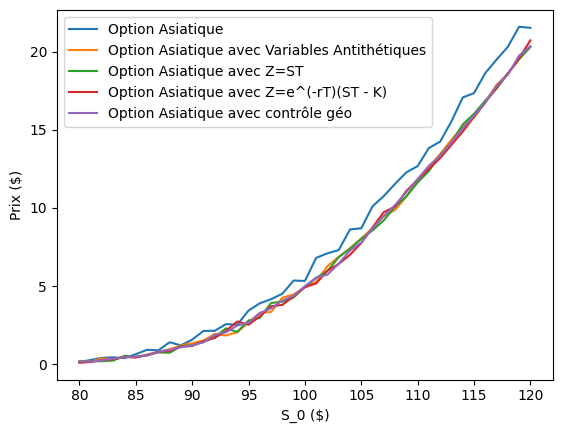

In [ ]:
asian_option_prices = call_asian(T, K, r, S0, sigma, N)
asian_antithetic_option_prices = call_asian_antithetic(T, K, r, S0, sigma, N)
call_asian_control_ST_option_prices = call_asian_control_ST(T, K, r, S0, sigma, N)
call_asian_control_exp_option_prices = call_asian_control_exp(T, K, r, S0, sigma, N)
call_asian_control_geo_option_prices = call_asian_control_geo(T, K, r, S0, sigma, N)

plt.plot(S0, asian_option_prices, label="Option Asiatique")
plt.plot(S0, asian_antithetic_option_prices, label="Option Asiatique avec Variables Antithétiques")
plt.plot(S0, call_asian_control_ST_option_prices, label="Option Asiatique avec Z=ST")
plt.plot(S0, call_asian_control_exp_option_prices, label="Option Asiatique avec Z=e^(-rT)(ST - K)")
plt.plot(S0, call_asian_control_geo_option_prices, label="Option Asiatique avec contrôle géo")
plt.xlabel("S_0 ($)")
plt.ylabel("Prix ($)")
plt.legend()
plt.show()

In [ ]:
asian_var_geo = np.zeros(len(N_sim))
for i, n_sim in enumerate(N_sim):
  n = int(n_sim)
  asian_geo = []
  for _ in range(Number_prices):
    asian_geo.append(call_asian_control_geo(T, K, r, S0_unique, sigma, n))
  asian_var_geo[i] = np.var(asian_geo)

Text(0.5, 1.0, "Variance d'un call asiatique en fonction du nombre \n de simulations de MC pour différentes méthodes de réduction \n de variance en échelle logarithmique")

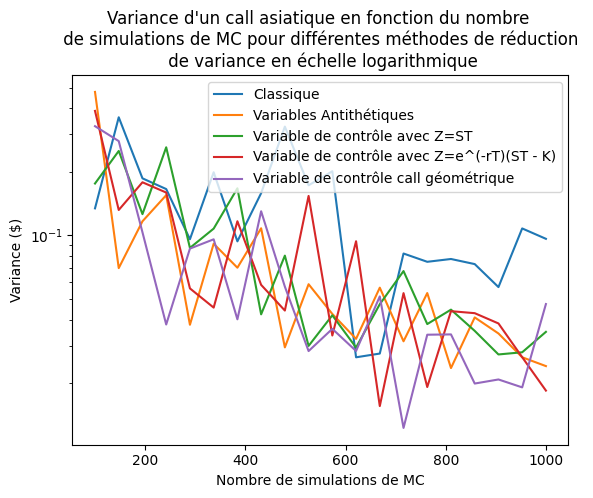

In [ ]:
plt.plot(N_sim, asian_var, label="Classique")
plt.plot(N_sim, asian_antithetic_var, label="Variables Antithétiques")
plt.plot(N_sim, asian_control_st_var, label="Variable de contrôle avec Z=ST")
plt.plot(N_sim, asian_control_exp_var, label="Variable de contrôle avec Z=e^(-rT)(ST - K)")
plt.plot(N_sim, asian_var_geo, label="Variable de contrôle call géométrique")
plt.legend()
plt.yscale("log")
plt.ylabel("Variance ($)")
plt.xlabel("Nombre de simulations de MC")
plt.title("Variance d'un call asiatique en fonction du nombre \n de simulations de MC pour différentes méthodes de réduction \n de variance en échelle logarithmique")

Text(0.5, 1.0, 'Facteur de réduction de variance en fonction du nombre \n de simulations de MC')

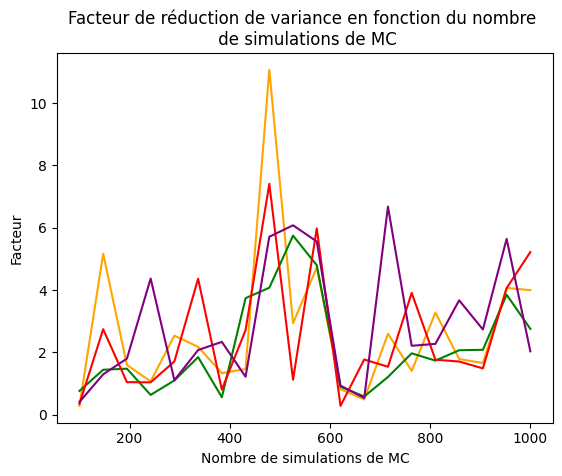

In [ ]:
plt.plot(N_sim, asian_var/asian_antithetic_var, label="Variables Antithétiques", color='orange')
plt.plot(N_sim, asian_var/asian_control_st_var, label="Variable de contrôle avec Z=ST", color='green')
plt.plot(N_sim, asian_var/asian_control_exp_var, label="Variable de contrôle avec Z=e^(-rT)(ST - K)", color='red')
plt.plot(N_sim, asian_var/asian_var_geo, label="Variable de contrôle call géométrique", color='purple')
plt.ylabel("Facteur")
plt.xlabel("Nombre de simulations de MC")
plt.title("Facteur de réduction de variance en fonction du nombre \n de simulations de MC")

En utilisant le prix du call géométrique comme variable de contrôle, nous obtenons un facteur de réduction de la variance similaire aux autres méthodes.